# ML Project: Diamond Quality
Eric López & Mustapha El Aichouni
## First analysis

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport
import src.utils as utils

In [2]:
df = pd.read_csv("data/diamonds.csv")

In [3]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [31]:
# profile_minimal = ProfileReport(df, minimal=True)
# profile_minimal.to_file("reports/diamonds_minimal_profiling_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

The minimal profiling report allows us to get a first impression of the whole dataset, while still not showing important statistics, as we haven't yet splitted into train and test set, and we are not interested in knowing about the test set.

We see that the dataset has no missing values, 3 categorical features and that the "Unnamed: 0" column corresponds to ids. We also get an idea of the type of values of each feature, so we can understand their meaning.

Now we do some basic preprocessing to handle these few problems we've seen, and separate into train and test set. Then we generate a more elaborated profiling report of the training data.

In [4]:
def basic_preprocessing(df: pd.DataFrame):
	df_copy = df.copy()

	# Encode categorical to numerical
	df_copy = utils.preprocessing_L(df_copy)

	# Split into X and y
	y = df_copy["cut"]
	X = df_copy.drop(columns=["cut", "Unnamed: 0"])

	# Split into train and test
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

	return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = basic_preprocessing(df)
X_train.head()

,carat,color,clarity,depth,table,price,x,y,z
26546,2.01,4,1,58.1,64.0,16231,8.23,8.19,4.77
9159,1.01,5,1,60.0,60.0,4540,6.57,6.49,3.92
14131,1.10,2,3,62.5,58.0,5729,6.59,6.54,4.10
15757,1.50,5,1,61.5,65.0,6300,7.21,7.17,4.42
24632,1.52,3,4,62.1,57.0,12968,7.27,7.32,4.53


In [6]:
# Generate the profiling report
# profile = ProfileReport(pd.concat([X_train, y_train], axis=1))

# Save the report as an HTML file
# profile.to_file("reports/diamonds_train_profiling_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

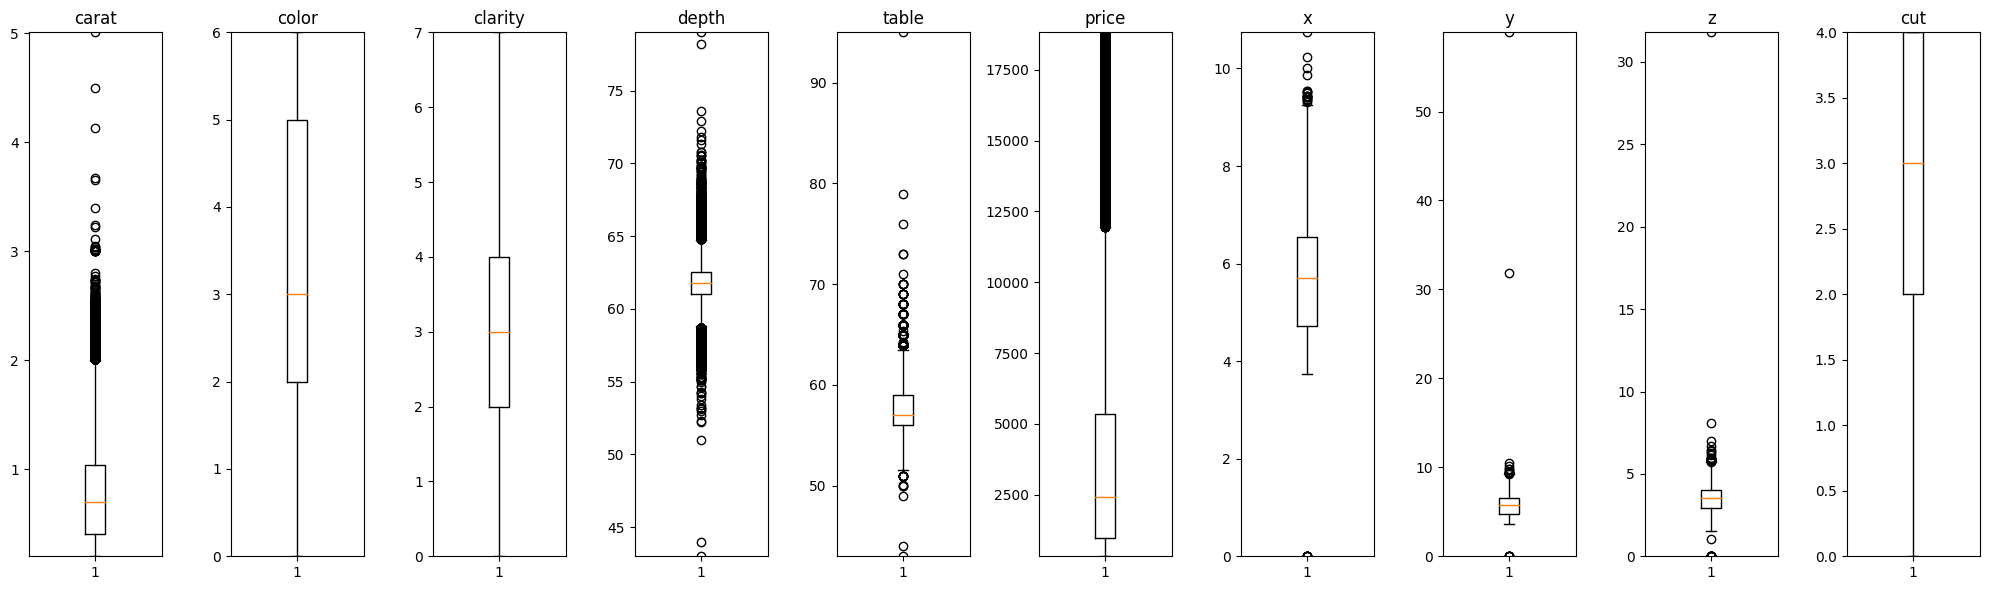

In [12]:
import matplotlib.pyplot as plt

df_train = pd.concat([X_train, y_train], axis=1)
features = df_train.columns
features_min = df_train.min()
features_max = df_train.max()

fig, axs = plt.subplots(1, len(features), figsize=(20, 6))

for i, feature in enumerate(features):
    axs[i].boxplot(df_train[feature])
    axs[i].set_ylim(features_min[feature], features_max[feature])
    axs[i].set_title(feature)

plt.tight_layout()

In [13]:
df_train_no_outliers = df_train.copy()

for feature in features:
	Q1 = df_train_no_outliers[feature].quantile(0.25)
	Q3 = df_train_no_outliers[feature].quantile(0.75)
	IQR = Q3 - Q1

	lower_bound = Q1 - 1.5 * IQR
	upper_bound = Q3 + 1.5 * IQR

	df_train_no_outliers = df_train_no_outliers[(df_train_no_outliers[feature] >= lower_bound) &
												(df_train_no_outliers[feature] <= upper_bound)]

<Figure size 2000x600 with 0 Axes>

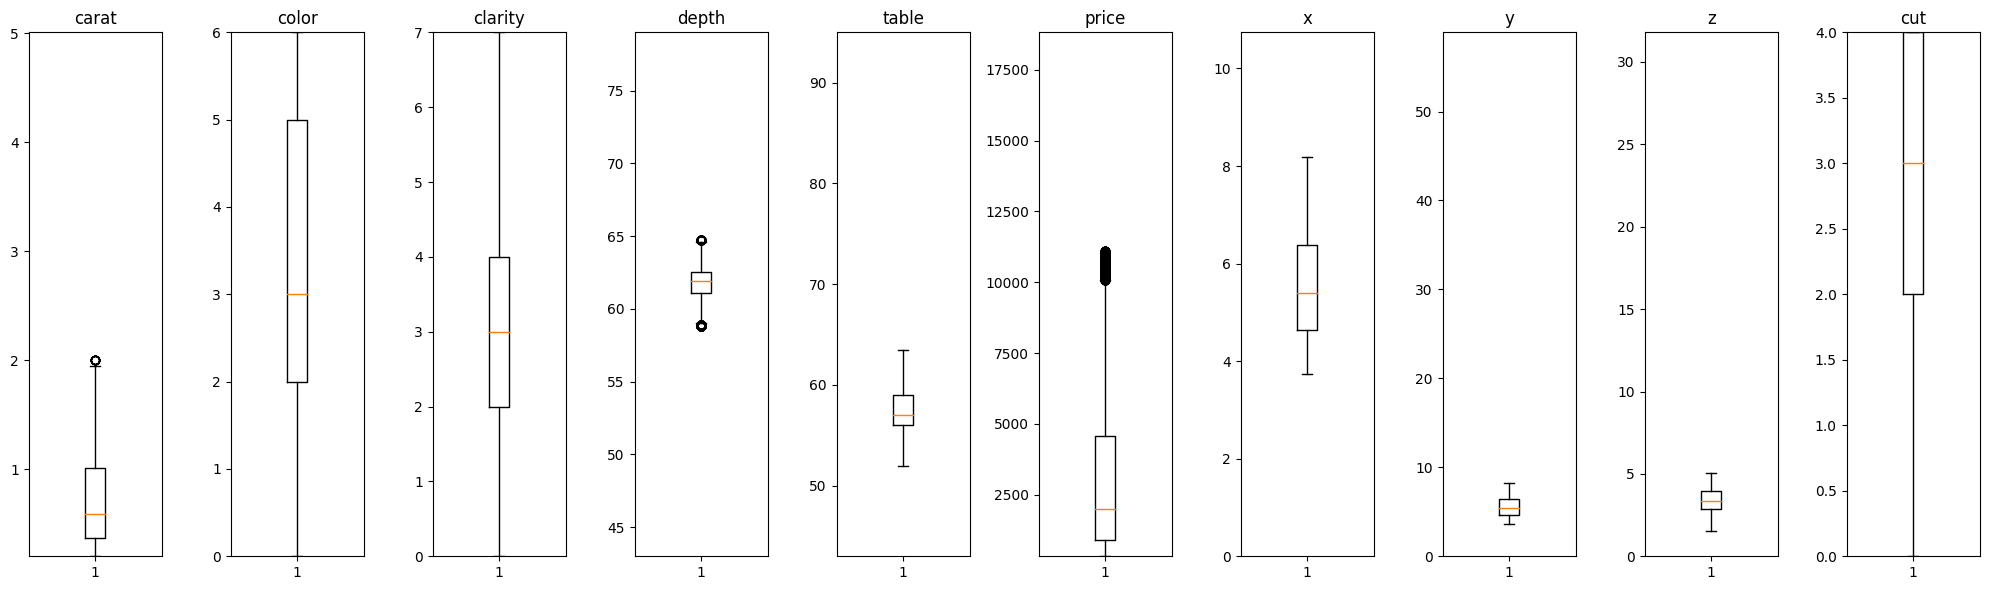

In [15]:
plt.figure(figsize=(20, 6))  # Adjust the size as needed

fig, axs = plt.subplots(1, len(features), figsize=(20, 6))

for i, feature in enumerate(features):
    axs[i].boxplot(df_train_no_outliers[feature])
    axs[i].set_ylim(features_min[feature], features_max[feature])
    axs[i].set_title(feature)

plt.tight_layout()

In [16]:
len(df_train) - len(df_train_no_outliers)

5583

## Ensemble
The models that achieved the best performance and we are interested in making an ensemble with them are: Random Forest, AdaBoost, Gradient Boosting, SVM and GMM.

In [24]:
import pandas as pd
import src.utils as utils
from sklearn.model_selection import train_test_split
from src.randomforest import RandomForest
from src.adaboost import AdaBoost
from src.gradboost import GradBoost
from src.svm_mod import SVM_model
from src.gmm import GMM
from src.ensemble import Ensemble

First, we split our data into train and test. We won't preprocess the test for now, as if it was a real case scenario, the test data doesn't come preprocessed, but raw.

In [30]:
df = pd.read_csv("data/diamonds.csv")
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
X_train2, X_val, y_train2, y_val = utils.preprocessing_LS(df_train)

We train a specific selection of our models (the ones that performed better), plus the GMM, that didn't have such good performance but we want to see if its unique perspective of gaussian distributions in the data can be useful in combination with other models.

In [31]:
rf = RandomForest(n_estimators=100, max_depth=16, bootstrap=True, class_weight="balanced")
ab = AdaBoost(n_estimators=100, max_depth=15, learning_rate=1.0, algorithm="SAMME")
gb = GradBoost(criterion="squared_error", max_depth=7, n_estimators=200)
gmm = GMM(n_components=10, max_iter=200, n_init=5, covariance_type="full", init_params="random")
svm = SVM_model(C=15, class_weight = 'balanced', max_iter=30000)

Now we train each model.

In [32]:
rf.fit(X_train2, y_train2)
print(f"Train accuracy: {rf.score(X_train2, y_train2):.2f}, Val accuracy: {rf.score(X_val, y_val):.2f}")

Train accuracy: 0.88, Val accuracy: 0.76


In [33]:
ab.fit(X_train2, y_train2)
print(f"Train accuracy: {ab.score(X_train2, y_train2):.2f}, Val accuracy: {ab.score(X_val, y_val):.2f}")

Train accuracy: 1.00, Val accuracy: 0.77


In [34]:
gb.fit(X_train2, y_train2)
print(f"Train accuracy: {gb.score(X_train2, y_train2):.2f}, Val accuracy: {gb.score(X_val, y_val):.2f}")

Train accuracy: 0.94, Val accuracy: 0.79


In [35]:
gmm.fit(X_train2, y_train2)
gmm_pred_train = gmm.predict(X_train2)
gmm_pred_val = gmm.predict(X_val)
print(f"Train accuracy: {gmm.score(y_train2, gmm_pred_train):.2f}, Val accuracy: {gmm.score(y_val, gmm_pred_val):.2f}")

Train accuracy: 0.69, Val accuracy: 0.69


In [36]:
svm.fit(X_train2, y_train2)
print(f"Train accuracy: {svm.score(X_train2, y_train2):.2f}, Val accuracy: {svm.score(X_val, y_val):.2f}")

c:\Users\pikur\anaconda3\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=30000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train accuracy: 0.78, Val accuracy: 0.76


Let's build our ensemble model, but first we try our custom class works well.

In [37]:
model_hard = Ensemble([rf, rf, rf],
					  voting="hard")

model_soft = Ensemble([rf, rf, rf],
					  voting="soft",
					  weights=None)

a_hard = model_hard.compute_metrics(X_val, y_val)["accuracy"]
a_soft = model_soft.compute_metrics(X_val, y_val)["accuracy"]
a_rf = rf.compute_metrics(X_val, y_val)["accuracy"]
a_hard, a_soft, a_rf

(0.7624840690534122, 0.7624840690534122, 0.7624840690534122)

It does, so we will now make an analysis on the best combination of models we can assemble and weather to use hard or soft voting and the weights.

In [38]:
model_hard = Ensemble([rf, ab, gb, gmm, svm],
				 voting="hard",
				 weights=None)

In [39]:
model_hard.compute_metrics(X_val, y_val)

{'accuracy': 0.7869308307264512,
 'precision': 0.7964676252757438,
 'recall': 0.7750758194307117,
 'f1': 0.7841460267923359}

In [40]:
model_soft = Ensemble([rf, ab, gb, gmm, svm],
				 voting="soft",
				 weights=None)

In [41]:
model_soft.compute_metrics(X_val, y_val)

{'accuracy': 0.7909859807670027,
 'precision': 0.7982599541859683,
 'recall': 0.7813685811352578,
 'f1': 0.7889221956090817}

At first glance, hard voting seems to perform very similar to soft voting, but for this last one we can still tune the weights and try to improve it. 

We know the best model we achieved was Gradient Boosting, and the worst GMM. We will balance this in the weights.

In [43]:
model_soft = Ensemble([rf, ab, gb, gmm, svm],
				 voting="soft",
				 weights=[0.2, 0.2, 0.3, 0.1, 0.2])
model_soft.compute_metrics(X_val, y_val)

{'accuracy': 0.7909859807670027,
 'precision': 0.8014394742268098,
 'recall': 0.7808152974819919,
 'f1': 0.7900169069821901}

It seems metrics haven't change at all. Maybe GMM is having a bad influence. Let's remove it.

In [44]:
model_hard = Ensemble([rf, ab, gb, svm],
				 voting="hard",
				 weights=None)
model_hard.compute_metrics(X_val, y_val)

{'accuracy': 0.7848453249913104,
 'precision': 0.7946686355265381,
 'recall': 0.7765073757108949,
 'f1': 0.7843192162132302}

In [45]:
model_soft = Ensemble([rf, ab, gb, svm],
				 voting="soft",
				 weights=None)
model_soft.compute_metrics(X_val, y_val)

{'accuracy': 0.7897115050399722,
 'precision': 0.7993032003376823,
 'recall': 0.7817278987329881,
 'f1': 0.7893108945971529}

Both hard and soft voting ensembles slightly decreased their metrics, but we can't take solid conclusions from this.  
Let's continue tunning the weights for the soft voting.

In [46]:
model_soft = Ensemble([rf, ab, gb, gmm, svm],
				 voting="soft",
				 weights=[0.3, 0.1, 0.3, 0.1, 0.2])
model_soft.compute_metrics(X_val, y_val)

{'accuracy': 0.7912177036264627,
 'precision': 0.8017770394578647,
 'recall': 0.7804830165111387,
 'f1': 0.789836261318783}

In [47]:
model_soft = Ensemble([rf, ab, gb, gmm, svm],
				 voting="soft",
				 weights=[0.2, 0.1, 0.4, 0.1, 0.2])
model_soft.compute_metrics(X_val, y_val)

{'accuracy': 0.7912177036264627,
 'precision': 0.7994027436936422,
 'recall': 0.7793773195073902,
 'f1': 0.7883133843718967}

In [31]:
model_soft = Ensemble([rf, ab, gb, gmm, svm],
				 voting="soft",
				 weights=[0.3, 0.4, 0.1, 0.1, 0.1])
model_soft.compute_metrics(X_val, y_val)

{'accuracy': 0.786235662148071,
 'precision': 0.785591917898857,
 'recall': 0.7699235853533363,
 'f1': 0.7750805071685475}

The weights that achieved best metrics so far are 0.3, 0.1, 0.3, 0.1, 0.2. Let's remove GMM this time by setting its weight to 0.

In [49]:
model_soft = Ensemble([rf, ab, gb, gmm, svm],
				 voting="soft",
				 weights=[0.3, 0.1, 0.3, 0., 0.2])
model_soft.compute_metrics(X_val, y_val)

{'accuracy': 0.7878577221642915,
 'precision': 0.7981237167541677,
 'recall': 0.7771356111987673,
 'f1': 0.7860670299051898}

All metrics slightly decreased, so GMM is actually having a good influence. We will keep it.

In [50]:
model_soft = Ensemble([rf, ab, gb, gmm, svm],
				 voting="soft",
				 weights=[2, 1, 2, 1, 1])
model_soft.compute_metrics(X_val, y_val)

{'accuracy': 0.7914494264859229,
 'precision': 0.8030078510869674,
 'recall': 0.7802983255178624,
 'f1': 0.7903306056194672}

In [54]:
model_soft = Ensemble([rf, ab, gb, gmm, svm],
				 voting="soft",
				 weights=[0.2, 0.4, 0.2, 0.1, 0.1])
model_soft.compute_metrics(X_val, y_val)

{'accuracy': 0.7911018421967327,
 'precision': 0.802750064642965,
 'recall': 0.7795575847771216,
 'f1': 0.7898116509700962}

In [52]:
model_soft = Ensemble([rf, ab, gb, gmm, svm],
				 voting="soft",
				 weights=[0.2, 0.2, 0.3, 0.1, 0.3])
model_soft.compute_metrics(X_val, y_val)

{'accuracy': 0.7909859807670027,
 'precision': 0.799878662165147,
 'recall': 0.7816772898790519,
 'f1': 0.7898046007007699}

The weigths that increase the overall metrics are: rf=0.3, ab=0.1, gb=0.3, gmm=0.1, svm=0.2, altough the difference is minimal with other similar combinations.

In [55]:
model_soft = Ensemble([rf, ab, gb, gmm, svm],
				 voting="soft",
				 weights=[0.3, 0.1, 0.3, 0.1, 0.2])
model_soft.compute_metrics(X_val, y_val)

{'accuracy': 0.7912177036264627,
 'precision': 0.8017770394578647,
 'recall': 0.7804830165111387,
 'f1': 0.789836261318783}

In [53]:
gb.compute_metrics(X_val, y_val)

{'accuracy': 0.7877418607345614,
 'precision': 0.7992968666880683,
 'recall': 0.7713695376020404,
 'f1': 0.7834591636545596}

The results are better than with hard voting and slightly better than the best single model, the Gradient Boosting.

### Testing time
Let's evaluate the ensemble model on the test set.

In [56]:
df = pd.read_csv("data/diamonds.csv")
X_train, X_test, y_train, y_test = utils.preprocessing_LS(df)

rf = RandomForest(n_estimators=100, max_depth=19, bootstrap=True, class_weight="balanced")
ab = AdaBoost(n_estimators=100, max_depth=15, learning_rate=1.0, algorithm="SAMME")
gb = GradBoost(criterion="squared_error", max_depth=7)
gmm = GMM(n_components=10, max_iter=200, n_init=5, covariance_type="full", init_params="random")
svm = SVM_model(C=15, class_weight = 'balanced', max_iter=30000)

rf.fit(X_train, y_train)
print("Random Forest trained")
ab.fit(X_train, y_train)
print("AdaBoost trained")
gb.fit(X_train, y_train)
print("Gradient Boost trained")
gmm.fit(X_train, y_train)
print("GMM trained")
svm.fit(X_train, y_train)
print("SVM trained")

Random Forest trained
AdaBoost trained
Gradient Boost trained
GMM trained
SVM trained


c:\Users\pikur\anaconda3\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=30000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [60]:
model_soft = Ensemble([rf, ab, gb, gmm, svm],
				 voting="soft",
				 weights=[0.3, 0.1, 0.3, 0.1, 0.2])
model_soft(X_test[:5])

array([4, 2, 4, 4, 4], dtype=int64)

In [62]:
model_soft.compute_metrics(X_test, y_test)

{'accuracy': 0.8058954393770856,
 'precision': 0.8128681637169406,
 'recall': 0.8002241381994472,
 'f1': 0.8054018586314591}

In [63]:
gb.compute_metrics(X_test, y_test)

{'accuracy': 0.8010752688172043,
 'precision': 0.8062076504258053,
 'recall': 0.7878131785705504,
 'f1': 0.7943005594005085}

The ensemble model performed better than the best single model on the test set. However, the difference is still very small.

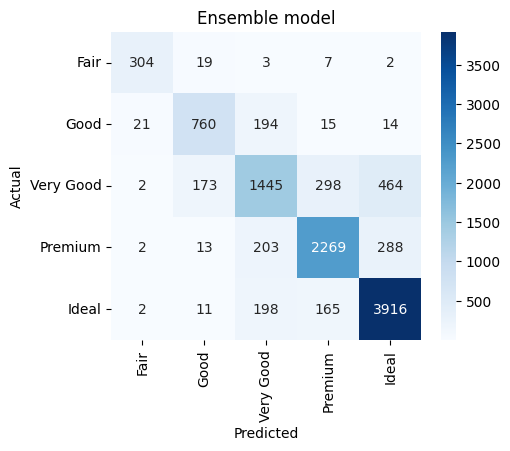

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
conf_mat = model_soft.conf_matrix(X_test, y_test, labels=list(range(5)))
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Ensemble model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

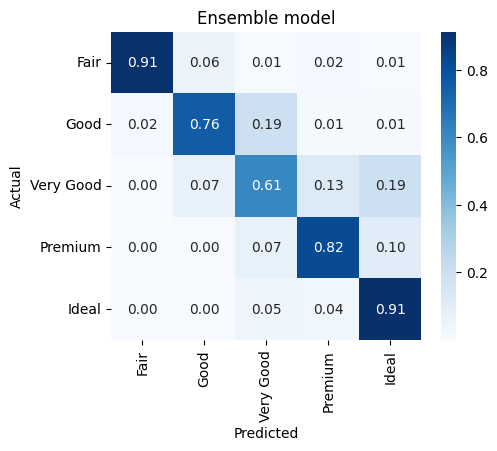

In [67]:
conf_mat = model_soft.conf_matrix(X_test, y_test, labels=list(range(5)), normalize="true")
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Ensemble model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Like some all of the single models, the ensemble struggles with class "Very good" (class 2). It has a good precision with the edge cases "Fair" and "Ideal".

In [69]:
from src.knn import KNN_model
from src.logreg import LogReg
from src.naive_bayes import GNaiveBayes

knn = KNN_model(n_neighbors=5, weights="uniform", p=1)
logreg = LogReg(class_weight="balanced")
nb = GNaiveBayes()

X_train_pls, X_test_pls, y_train_pls, y_test_pls = utils.preprocessing_PLS(df)
X_train_los, X_test_los, y_train_los, y_test_los = utils.preprocessing_LOS(df)

knn.fit(X_train_los, y_train_los)
print("KNN trained")
logreg.fit(X_train_pls, y_train_pls)
print("LogReg trained")
nb.fit(X_train_los, y_train_los)
print("Naive Bayes trained")

KNN trained
LogReg trained
Naive Bayes trained


In [72]:
logreg_metrics = logreg.compute_metrics(X_test_pls, y_test_pls)
svm_metrics = svm.compute_metrics(X_test, y_test)
rf_metrics = rf.compute_metrics(X_test, y_test)
ab_metrics = ab.compute_metrics(X_test, y_test)
gb_metrics = gb.compute_metrics(X_test, y_test)
gmm_metrics = gmm.compute_metrics(X_test, y_test)
knn_metrics = knn.compute_metrics(X_test, y_test)
nb_metrics = nb.compute_metrics(X_test, y_test)
e_metrics = model_soft.compute_metrics(X_test, y_test)

In [81]:
e_metrics = model_soft.compute_metrics(X_test, y_test)

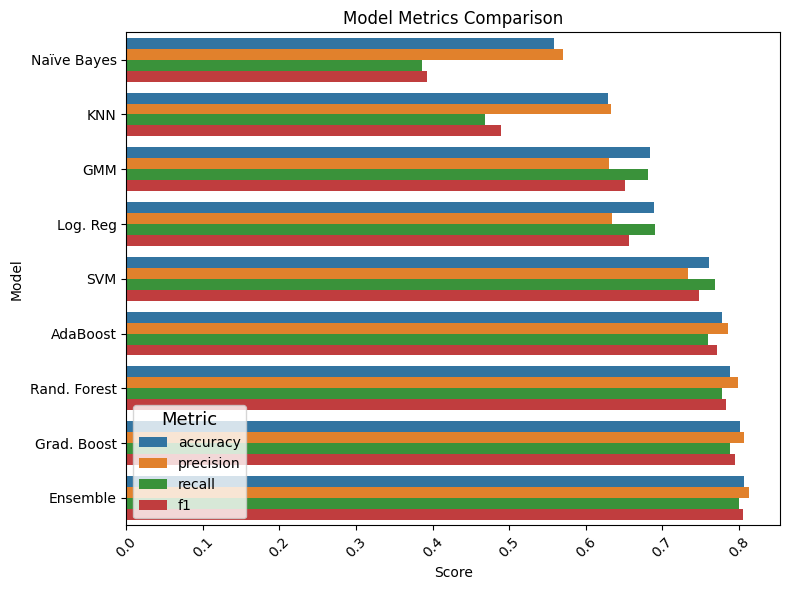

In [91]:
metrics_df = pd.DataFrame({
    'Log. Reg': logreg_metrics,
    'SVM': svm_metrics,
    'Rand. Forest': rf_metrics,
    'AdaBoost': ab_metrics,
    'Grad. Boost': gb_metrics,
    'GMM': gmm_metrics,
    'KNN': knn_metrics,
    'Naïve Bayes': nb_metrics,
	'Ensemble': e_metrics
}).T

metrics_df = metrics_df.sort_values(by='accuracy')

# Reshape the DataFrame
metrics_df_melted = metrics_df.reset_index().melt(id_vars='index')

plt.figure(figsize=(8, 6))
sns.barplot(y='index', x='value', hue='variable', data=metrics_df_melted)
plt.title('Model Metrics Comparison')
plt.xlabel('Score')
plt.ylabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Metric', title_fontsize='13', loc='lower left')
plt.tight_layout()
plt.show()